In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ipywidgets as widgets

from matplotlib import pyplot as plt
from os import listdir, path, curdir
from os.path import isfile, join
from pathlib import Path
from tqdm import tqdm
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

In [86]:
def generate_general_statistics(state, data, statistics):
    statistics['state'].append(state)
    statistics['electorate'].append(data['QT_APTOS'].sum())
    statistics['mean_electorate'].append(data.groupby('id').agg('sum')['QT_APTOS'].mean())
    statistics['std_electorate'].append(data['QT_APTOS'].std())
    statistics['turnout'].append(data['QT_COMPARECIMENTO'].sum())
    statistics['mean_turnout'].append(data.groupby('id').agg('sum')['QT_COMPARECIMENTO'].mean())
    statistics['std_turnout'].append(data['QT_COMPARECIMENTO'].std())
    statistics['polling_places'].append(len(data.groupby('id')))
    return statistics


def generate_precision_statistics(data, statistics):
    local_data = data[['precision', 'id']].groupby('id').first()
    n_precisions = local_data['precision'].value_counts()

    try:
        statistics['tse'].append(n_precisions['TSE'])
    except:
        statistics['tse'].append(0)

    try:
        statistics['rooftop'].append(n_precisions['ROOFTOP'])
    except:
        statistics['rooftop'].append(0)

    try:
        statistics['geometric_center'].append(n_precisions['GEOMETRIC_CENTER'])
    except:
        statistics['geometric_center'].append(0)

    try:
        statistics['range_interpolated'].append(
            n_precisions['RANGE_INTERPOLATED'])
    except:
        statistics['range_interpolated'].append(0)

    try:
        statistics['approximated'].append(n_precisions['APPROXIMATE'])
    except:
        statistics['approximated'].append(0)

    try:
        statistics['no_value'].append(n_precisions['NO_VALUE'])
    except:
        statistics['no_value'].append(0)
    return statistics


def generate_statistics(election_data,
                        area_filter='all',
                        precision_filter='all'):
    statistics = {
        'state': [],
        'electorate': [],
        'mean_electorate' : [],
        'std_electorate' : [],
        'turnout': [],
        'mean_turnout': [],
        'std_turnout': [],
        'polling_places':[],
        'tse': [],
        'rooftop': [],
        'geometric_center': [],
        'range_interpolated': [],
        'approximated': [],
        'no_value': []
    }

    for state, data in election_data:
        #filtering data by area
        if area_filter == 'Capital':
            data = data[data['capital'] == True]
        elif area_filter == 'Rural':
            data = data[data['rural'] == True]
        elif area_filter == 'Interior':
            data = data[data['capital']==False]
            data = data[data['rural']==False]
        elif area_filter == 'Not Capital':
            data = data[data['capital']==False]

        #filtering data by precision
        if precision_filter == 'TSE':
            data = data[data['precision'] == 'TSE']
        elif precision_filter == 'Rooftop':
            data = data[data['precision'] == 'ROOFTOP']
        elif precision_filter == 'Others':
            data = data[data['precision'] != 'TSE']
            data = data[data['precision'] != 'ROOFTOP']
            

        #General statistics
        statistics = generate_general_statistics(state, data, statistics)
        
        #Precision statistics
        statistics = generate_precision_statistics(data, statistics)

    return pd.DataFrame(statistics)

In [102]:
def generate_electorate_single_plot(election_statistics, field):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.tight_layout()

    plot_electorate = sns.barplot(ax=ax,
                                  x='state',
                                  y=field,
                                  data=election_statistics,
                                  color='#59a2cb')
    if field == 'electorate':
        title = "Electorate Size"
    elif field == 'turnout':
        title = "Turnout"
    elif field == 'mean_electorate':
        title = "Mean Electorate By Polling Places"
    elif field == 'mean_turnout':
        title = "Mean Turnout By Polling Places"
    ax.title.set_text(title)
    ax.set(xlabel="States", ylabel="Number of voters")

    #vals = ax[1].get_yticks()
    #ax[1].set_yticklabels(['{:.0}'.format(x) for x in vals])
    plt.subplots_adjust(hspace=0.01)
    
    fig.show()
    return None



def generate_electorate_size_plot(election_statistics, field):

    election_statistics['%' + field] = 100 * election_statistics[
        field] / election_statistics[field].sum()
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    fig.tight_layout()

    plot_electorate = sns.barplot(ax=ax[0],
                                  x='state',
                                  y=field,
                                  data=election_statistics,
                                  color='#59a2cb')
    if field == 'electorate':
        title = "Electorate Size"
    elif field == 'turnout':
        title = "Turnout"
    elif field == 'mean_electorate':
        title = "Mean Electorate By Polling Places"
    elif field == 'mean_turnout':
        title = "Mean Turnout By Polling Places"
    ax[0].title.set_text(title)
    ax[0].set(xlabel="", ylabel="Number of voters (1e6)")
    ax[0].set_xticks([])

    plot_electorate = sns.barplot(ax=ax[1],
                                  x='state',
                                  y='%' + field,
                                  data=election_statistics,
                                  color='#f85050')
    ax[1].set(xlabel="States", ylabel="Percentual of voters (%)")

    #vals = ax[1].get_yticks()
    #ax[1].set_yticklabels(['{:.0}'.format(x) for x in vals])
    plt.subplots_adjust(hspace=0.01)
    return (fig)


def stacked_data(top_statistics,
                 bottom_statistics,
                 middle_statistics,
                 field='electorate',
                 legend=['Capital', 'Rural', 'Interior'],
                 sum_middle=True):
    
    #Set general plot properties
    sns.set_context({"figure.figsize": (30, 17)})

    #Plot 1 - background - "total" (top) series
    sns.barplot(x=top_statistics.state,
                y=top_statistics[field],
                color="#f85050")

    #Plot 2 - overlay - "middle" series
    if sum_middle:
        series_to_plot = bottom_statistics[field] + middle_statistics[field]
        middle_plot = sns.barplot(x=middle_statistics.state,
                                  y=series_to_plot,
                                  color="#2b7c56")
    else:
        middle_plot = sns.barplot(x=middle_statistics.state,
                                  y=middle_statistics[field],
                                  color="#2b7c56")

    #Plot 3 - overlay - "bottom" series
    bottom_plot = sns.barplot(x=bottom_statistics.state,
                              y=bottom_statistics[field],
                              color="#59a2cb")

    topbar = plt.Rectangle((0, 0), 1, 1, fc="#f85050", edgecolor='none')
    bottombar = plt.Rectangle((0, 0), 1, 1, fc='#59a2cb', edgecolor='none')
    middlebar = plt.Rectangle((0, 0), 1, 1, fc='#2b7c56', edgecolor='none')

    l = plt.legend([bottombar, middlebar, topbar],
                   legend,
                   loc=1,
                   ncol=3,
                   prop={'size': 25})
    l.draw_frame(False)

    #Optional code - Make plot look nicer
    #sns.despine(left=True)
    bottom_plot.set_ylabel("Number of voters")
    bottom_plot.set_xlabel("States")

    #Set fonts to consistent 16pt size
    for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
                 bottom_plot.get_xticklabels() +
                 bottom_plot.get_yticklabels()):
        item.set_fontsize(25)

# Step 1 - Load the data

<b>Select the folder where all electoral data are:</b>

In [4]:
# Create and display a FileChooser widget
ROOT_DIR = path.abspath(curdir)
fc = FileChooser(ROOT_DIR)
fc.use_dir_icons = True
#fc.title = '<b>Choose a folder</b>'

election_data = []
def load_data(chooser):
    global election_data
    
    selected_path = chooser.selected_path
    try:
        filenames = [
            filename for filename in listdir(selected_path)
            if isfile(join(selected_path, filename))
        ]

        for file in tqdm(filenames):
            data = pd.read_csv(selected_path + '\\' + file)
            state = file.split('.')[0]
            election_data = election_data + [(state, data)]
    except:
        print("An erro occur, please check the folder selected.")


# Register callback function
fc.register_callback(load_data)
display(fc)

FileChooser(path='C:\Users\Tiago\Documents\GitHub\Election_Forensics\notebooks\report', filename='', show_hidd…

100%|██████████████████████████████████████████| 27/27 [00:04<00:00,  6.17it/s]


# Step 2 - Filter the data

<b>Select the type of area to filter the data:</b>

In [22]:
dropdown_area = widgets.Dropdown(options=['TSE', 'Rooftop', 'Others'])
output_table = widgets.Output()
output_electorate_plot = widgets.Output()
output_turnout_plot = widgets.Output()


def dropdown_area_eventhandler(change):
    output_table.clear_output()
    output_electorate_plot.clear_output()
    output_turnout_plot.clear_output() 

    election_statistics = generate_statistics(election_data,
                                              precision_filter=change.new)
    with output_table:
        display(election_statistics)
    with output_electorate_plot:
        plot = generate_electorate_size_plot(election_statistics,
                                             field='electorate')
        plt.show()
    with output_turnout_plot:
        plot = generate_electorate_size_plot(election_statistics,
                                             field='turnout')
        plt.show()

dropdown_area.observe(dropdown_area_eventhandler, names='value')

display(dropdown_area)
#display(output_table)

Dropdown(options=('TSE', 'Rooftop', 'Others'), value='TSE')

# <center> Data Visualization </center> 

## Electorate size plot
This plot represents the size of the electorate per state. It is possible to change the plot by selecting specific areas. The percentages presented in this plot are calculated considering the sum of all states number of voters for the type of precision selected (Others, TSE, or Rooftop). 

In [15]:
display(output_electorate_plot)

Output()

## Electorate size stacked plot 
This plot shows the composition of the electorate of bad precision places by geocoded precision category.
PS: Run this cell after loading the data.

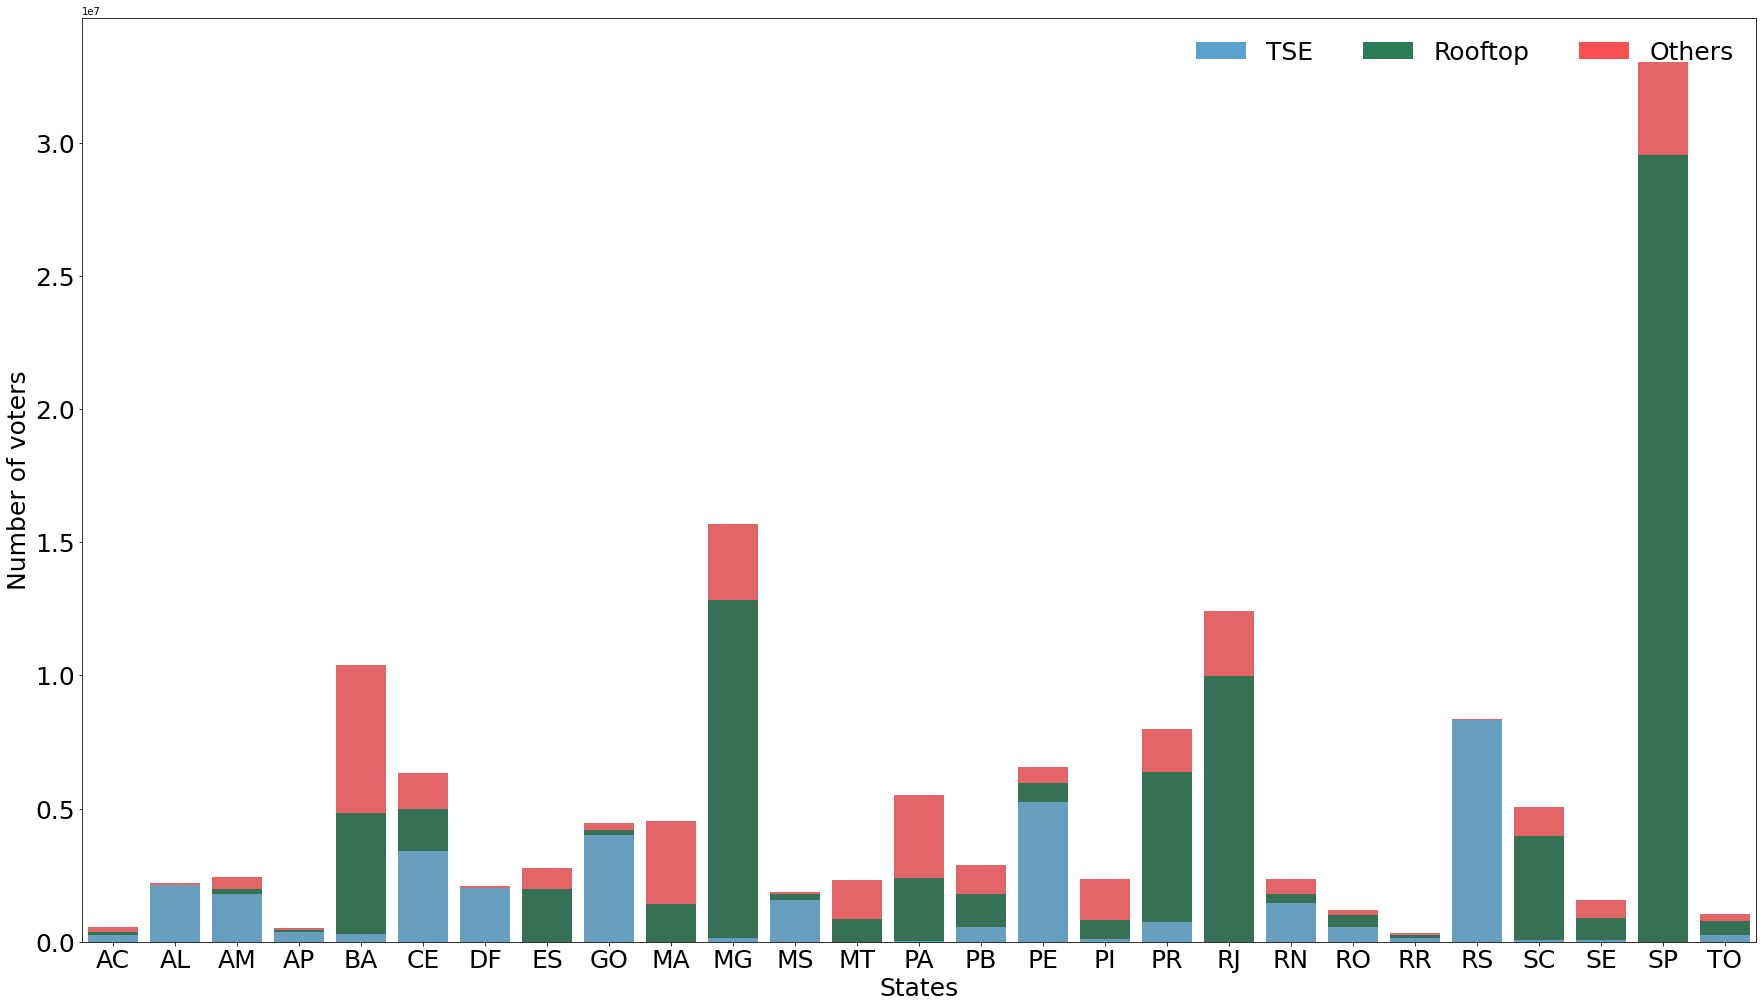

In [31]:
try:
    all_statistics = generate_statistics(election_data, precision_filter='All')
    tse_statistics = generate_statistics(election_data, precision_filter='TSE')
    rooftop_statistics = generate_statistics(election_data, precision_filter='Rooftop')

    stacked_data(all_statistics, tse_statistics, rooftop_statistics, legend=['TSE', 'Rooftop', 'Others'])
except:
    print("An error occur, please check the selected folder.")

In [33]:
total_size = all_statistics.electorate.sum()
tse_size = tse_statistics.electorate.sum()
rooftop_size = rooftop_statistics.electorate.sum()
other_size = total_size - tse_size - rooftop_size
print(
    "Electorate size - Total: {}, TSE: {}, Rooftop: {}, Others: {}".format(
        total_size, tse_size, rooftop_size, other_size))

other_perc = 100 * other_size / total_size
tse_perc = 100 * tse_size / total_size
rooftop_perc = 100 * rooftop_size / total_size
print("Electorate size (%) - Others: {}, TSE: {}, Rooftop: {}".format(
    other_perc, tse_perc, rooftop_perc))



Electorate size - Total: 146830967, TSE: 33429439, Rooftop: 80383206, Others: 33018322
Electorate size (%) - Others: 22.487301333376085, TSE: 22.767294721964202, Rooftop: 54.745403944659714


## Turnout plot
This plot represents the turnout of the electorate per state. It is possible to change the plot by selecting specific areas in the Step 2. The percentages presented in this plot are calculated considering the sum of all states number of voters for the type of precisions selected (Others, TSE, or Rooftop). 

In [23]:
display(output_turnout_plot)

Output()

## Turnout stacked plot
This plot shows the composition of the turnout electorate by geocoded precision category.
PS: Run this cell after loading the data.

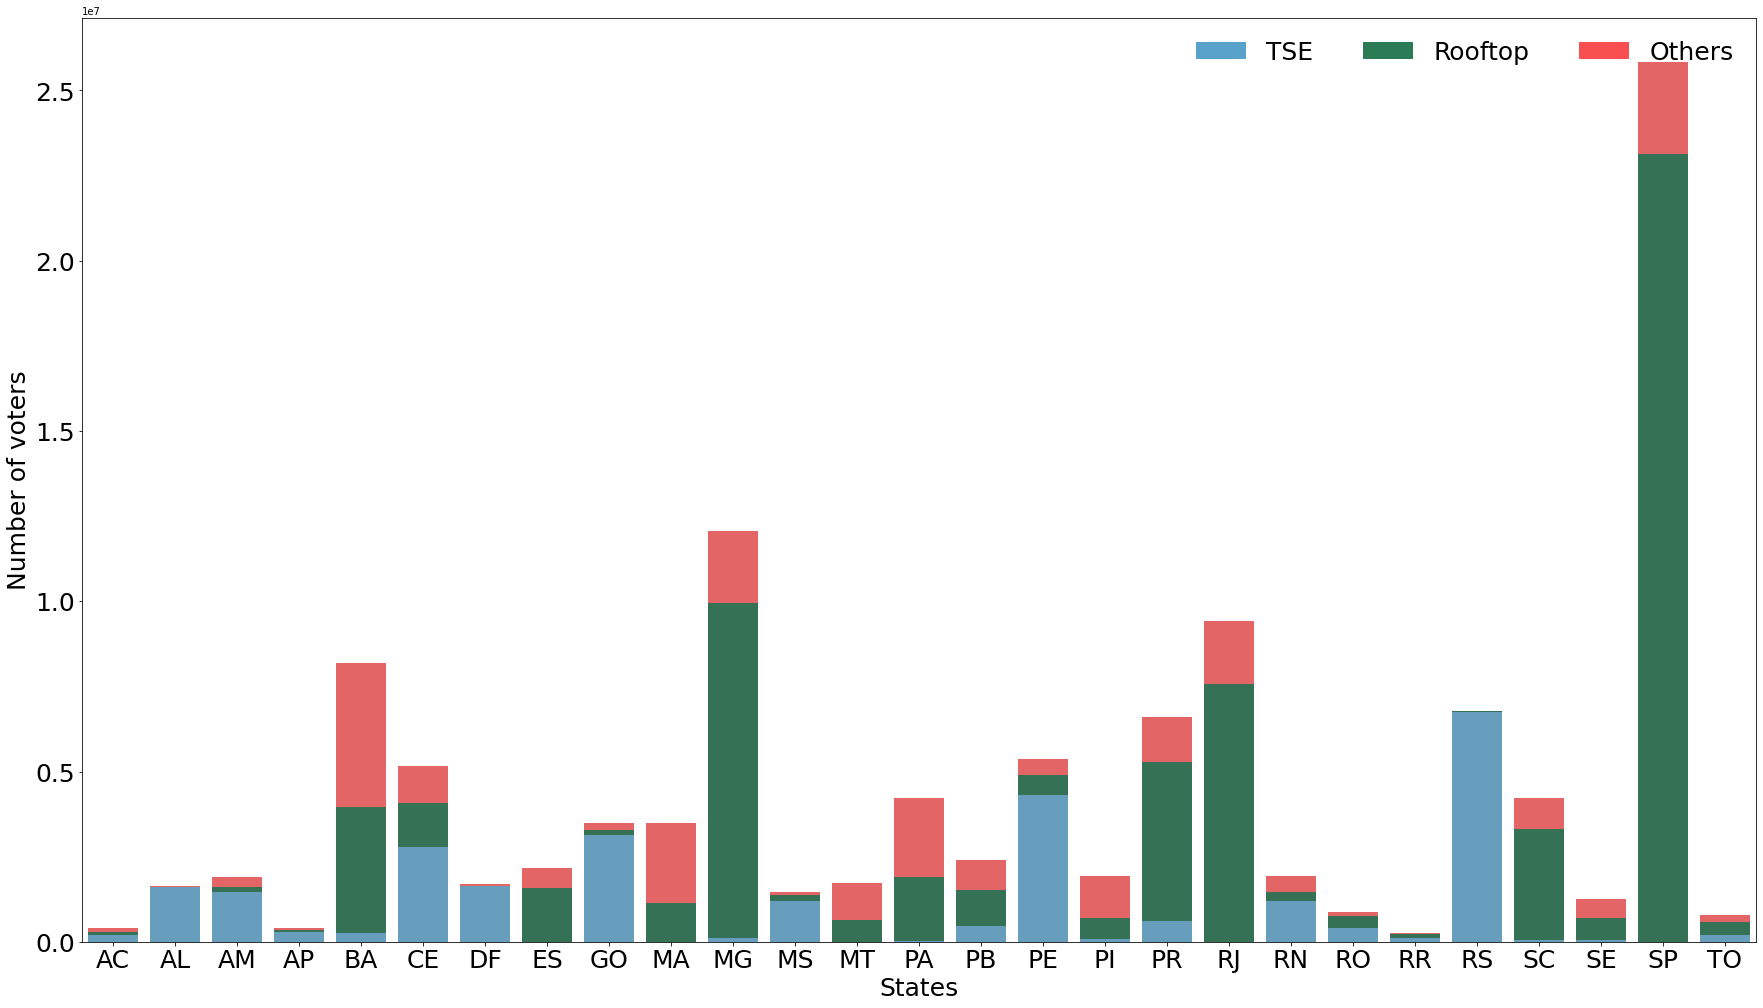

In [35]:
try:
    stacked_data(all_statistics,
                 tse_statistics,
                 rooftop_statistics,
                 legend=['TSE', 'Rooftop', 'Others'],
                 field='turnout')
except:
    print("An error occur, please check the selected folder.")

In [37]:
total_size = all_statistics.turnout.sum()
tse_size = tse_statistics.turnout.sum()
rooftop_size = rooftop_statistics.turnout.sum()
other_size = total_size - tse_size - rooftop_size
print(
    "Electorate size - Total: {}, TSE: {}, Rooftop: {}, Others: {}".format(
        total_size, tse_size, rooftop_size, other_size))

other_perc = 100 * other_size / total_size
tse_perc = 100 * tse_size / total_size
rooftop_perc = 100 * rooftop_size / total_size
print("Electorate size (%) - Others: {}, TSE: {}, Rooftop: {}".format(
    other_perc, tse_perc, rooftop_perc))


Electorate size - Total: 115754230, TSE: 26955970, Rooftop: 63352363, Others: 25445897
Electorate size (%) - Others: 21.982692986683944, TSE: 23.287244016914112, Rooftop: 54.73006299640195


# <center> Analysis </center>
Polling places with rooftop or tse precision represents 79% of the Brazilian electorate, it corresponds to a representative portion of election results. However, the remaining 21% of the electorate corresponds to 33 millions of votes, which in a general view seems a representative number of votes. On the other hand, in a micro perspective it is importante to verify how fragmented are these 33 millions votes across the brazilian territory. As a first analisys we can check the ratio of turnouts and electorate size for the polling places with bad precision considering only those which are in the interior and rural areas (37636).     

In [85]:
interior_statistics = generate_statistics(election_data,
                                          area_filter='Interior',
                                          precision_filter='Others')
rural_statistics = generate_statistics(election_data,
                                       area_filter='Rural',
                                       precision_filter='Others')
total_electorate = interior_statistics.electorate.sum(
) + rural_statistics.electorate.sum()

total_turnout = interior_statistics.turnout.sum(
) + rural_statistics.turnout.sum()
print(
    "Electorate size of polling places with bad precision in Interior and rural area: {}"
    .format(total_electorate))
print("Electorate size ratio by polling places: {}".format(total_electorate/37636))
print(
    "Turnout of polling places with bad precision in Interior and rural area: {}"
    .format(total_turnout))
print("Turnout ratio by polling places: {}".format(total_turnout/37636))

Electorate size of polling places with bad precision in Interior and rural area: 30520151
Electorate size ratio by polling places: 810.9297215432033
Turnout of polling places with bad precision in Interior and rural area: 23405868
Turnout ratio by polling places: 621.901052184079


In [53]:
interior_statistics = generate_statistics(election_data,
                                          area_filter='Interior',
                                          precision_filter='All')
rural_statistics = generate_statistics(election_data,
                                       area_filter='Rural',
                                       precision_filter='All')
total_electorate = interior_statistics.electorate.sum(
) + rural_statistics.electorate.sum()

total_turnout = interior_statistics.turnout.sum(
) + rural_statistics.turnout.sum()
print(
    "Electorate size of polling places in the interior and rural area: {}"
    .format(total_electorate))
print("Electorate size ratio by polling places: {}".format(total_electorate/59988))
print(
    "Turnout of polling places in the interior and rural area: {}"
    .format(total_turnout))
print("Turnout ratio by polling places: {}".format(total_turnout/59988))

Electorate size of polling places in the interior and rural area: 112414650
Electorate size ratio by polling places: 1873.9522904580915
Turnout of polling places in the interior and rural area: 87998731
Turnout ratio by polling places: 1466.938904447556


The ratio of voter per polling place indicates that there is less voters in the polling places with bad geocoding when compared to the entire number of polling places in the interior and rural areas


## Mean of voters per polling places plot

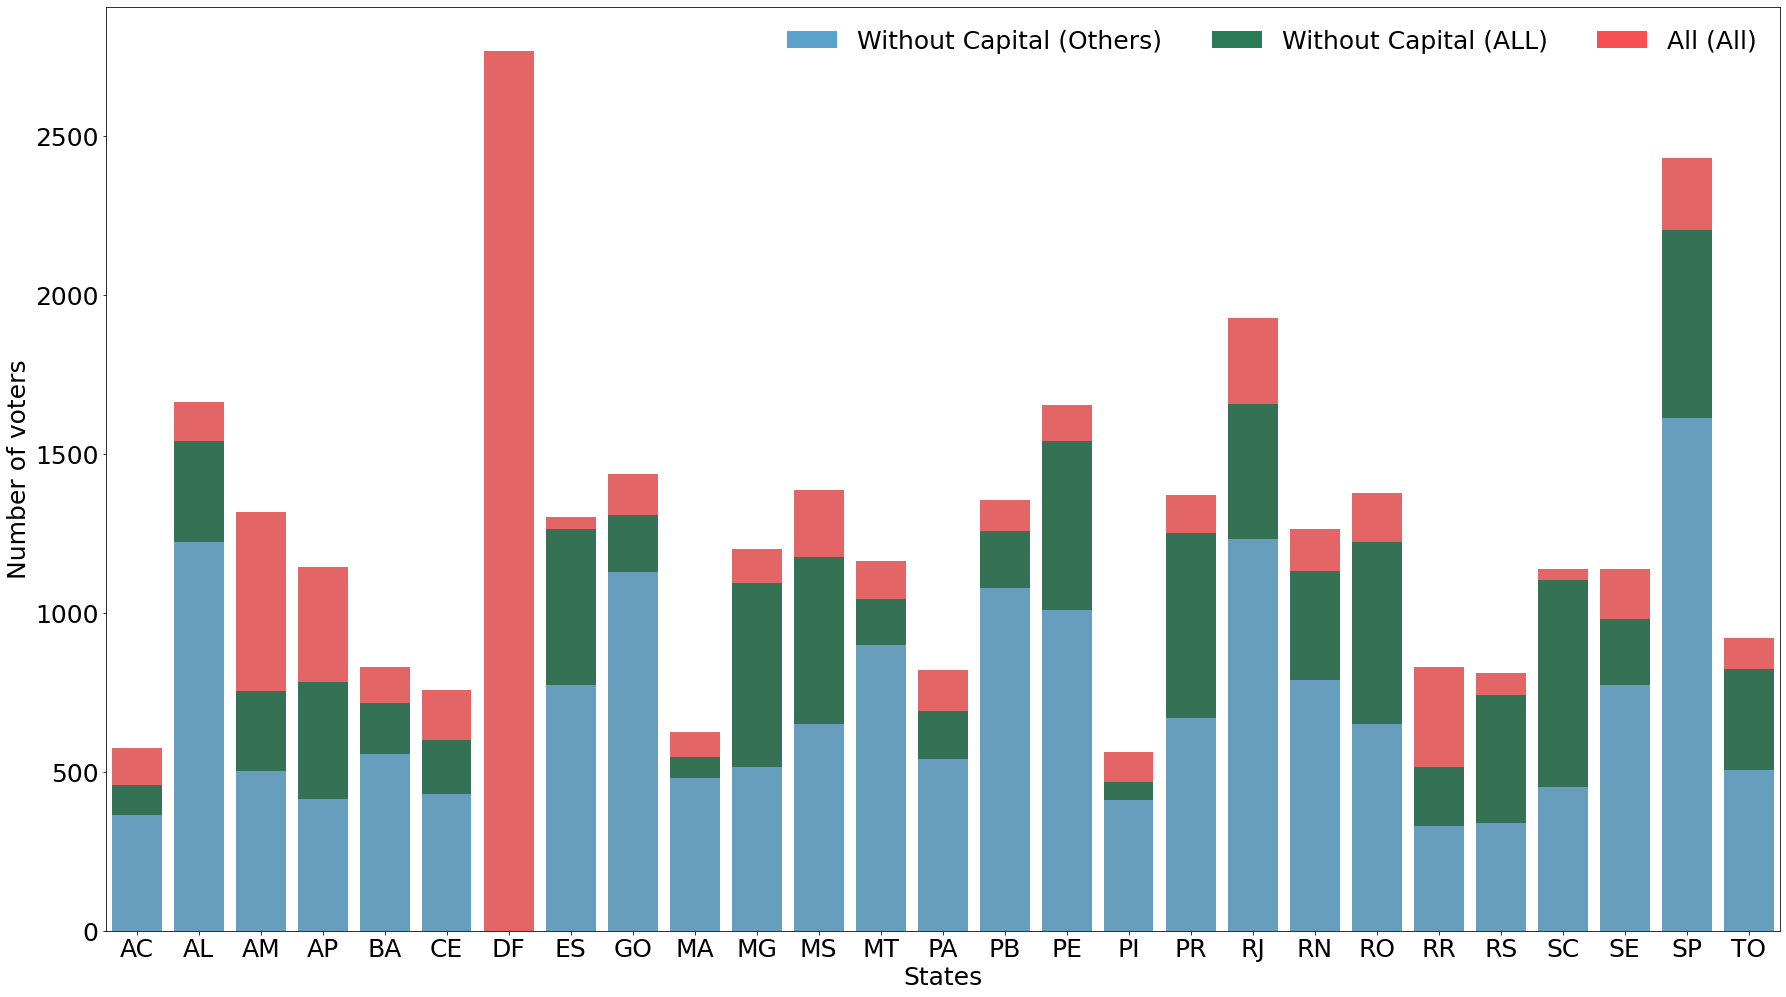

In [105]:
try:
    all_statistics = generate_statistics(election_data,
                                         area_filter='All',
                                         precision_filter='All')
    interior_statistics = generate_statistics(election_data,
                                              area_filter='Not Capital',
                                              precision_filter='All')

    interior_other_statistics = generate_statistics(election_data,
                                              area_filter='Not Capital',
                                              precision_filter='Others')

    stacked_data(all_statistics,
                 interior_other_statistics,
                 interior_statistics,
                 legend=['Without Capital (Others)', 'Without Capital (ALL)', 'All (All)'],
                 sum_middle=False,
                 field='mean_turnout')
except:
    print("An error occur, please check the selected folder.")

In all states there is a decrease in the mean of 